In [74]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("nbagg")   #подключить эти пакеты для анимации

In [99]:
Tlen = 20
dt = 0.0005  
nt = int(Tlen/dt)        # number of time steps
nx = 16        # number of grid points in x 
nz = nx         # number of grid points in z
isnap = 600     # snapshot frequency ???
L = np.pi       # coordinate region
iplot = 1000
dx = L/(nx-1)     # calculate space increment
f  = np.linspace(-L/2,L/2, nx) # initialize space coordinates
p  = np.linspace(-L/2,L/2, nx) # initialize space coordinates
t   = np.arange(1, nt+1)*dt  # initialize time axis

# initialization of pressure fields
 
sp = np.zeros((nx, nz), dtype= float)
#spnew = np.zeros((nx, nz), dtype=float) #разве мне нужен spnew? зачем перезаписывать матрицу каждый раз?
sd2pp = np.zeros((nx, nz), dtype=float) # матрица для производной по p
sd2pf = np.zeros((nx, nz), dtype=float) # матрица для производной по f

In [100]:
dt

0.0005

In [101]:
dx

0.20943951023931953

$\frac{\partial\rho}{\partial t} = -p\frac{\partial\rho}{\partial \varphi}-Forse(t,\varphi)\frac{\partial\rho}{\partial p}$ 

$\frac{\partial \rho}{\partial \varphi} = F^{-1}[ik_\varphi*F[\rho]]$

$\frac{\partial \rho}{\partial p} = F^{-1}[ik_p*F[\rho]]$

where $F^{-1}[.]$ - innverse Fourier transform.

$\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1}-\rho^{n}}{dt}$

$\rho^{n+1} = \rho^{n} - dt(p*F^{-1}[ik_\varphi*F[\rho]]+Forse*F^{-1}[ik_p*F[\rho]])$


In [102]:
# надо задать функцию ФТ
# предложение: задать две
# предложение опровергнуто. попробуй с одной
def fourier_derivative(f, dx):    
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)                                   # не до конца понимаю это место.
    k = np.arange(float(nx))                               # хотя сама делала что-то похожее с hstack
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)*ff
    df_num = np.real(np.fft.ifft(ff)) 
    return df_num 

In [103]:
# функця плотности распределенич
def rho1(x, z):                          # функция работает как надо
    return np.e**(-(x**2+z**2)/2)*(2*np.pi)**(-1)
beg = np.zeros((nx, nz), dtype= float) #матрица нулей для начального распределения
for i in range(nx): #заполняем значениями функции в узлах
    for j in range(nz):
        beg[i,j] =  rho1(f[i], p[j])

<IPython.core.display.Javascript object>


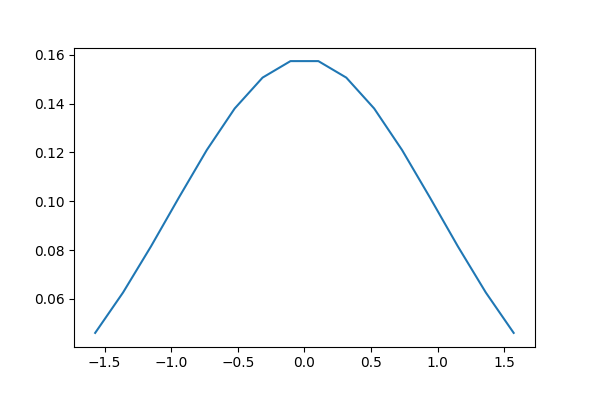

In [104]:
#это начальное распределение
plt.plot(f,beg[:,int(nx/2)])
plt.show()

$H(f,p) = \frac{p^2}{2}+\frac{f^2}{2}$

$Forse = -\frac{\partial U(f)}{\partial f}$

In [105]:
def H(f,p):
    return p**2/2 + f**2/2 
def F(f):
    return -f #-np.gradient(H(f,0)) - так было

<IPython.core.display.Javascript object>


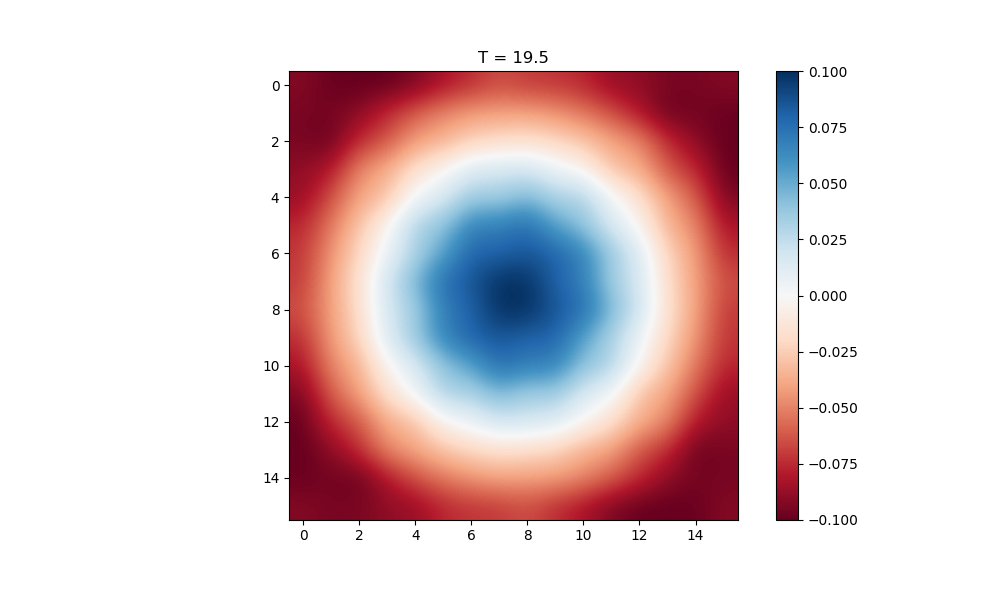

In [106]:
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
plt.imshow(sp, interpolation="bicubic", cmap=plt.cm.RdBu)
plt.title('Fourier Method', size=14,)
plt.colorbar()
plt.ion()   # set interective mode
plt.show()

In [107]:
sp = beg #в нулевой момент времнени плотность равна НУ

for it in range(nt):
   
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------
    # space derivative
    
    for j in np.arange(nz):           
        sd2pp[:,j] = F(f)[j]*fourier_derivative(sp[:,j].T, dx) #F(f)[j]*fourier_derivative(sp[:,j].T, dx) #jй столбец, по p
    for i in np.arange(nx):           
        sd2pf[i,:] = p[i]*fourier_derivative(sp[i,:], dx) #p[i]*fourier_derivative(sp[i,:], dx) #iя ст рока, по q
 
        
    # Time Extrapolation
    sp = sp - dt*(sd2pp + sd2pf)    
    #sp = spnew # Time levels
    
    if not it % iplot:                    
        # Display Solution
        # -------------------------------------- 
        plt.imshow(sp, interpolation="bicubic", cmap=plt.cm.RdBu) 
        plt.title("T = {}".format(it*dt))
        plt.gcf().canvas.draw()

<IPython.core.display.Javascript object>


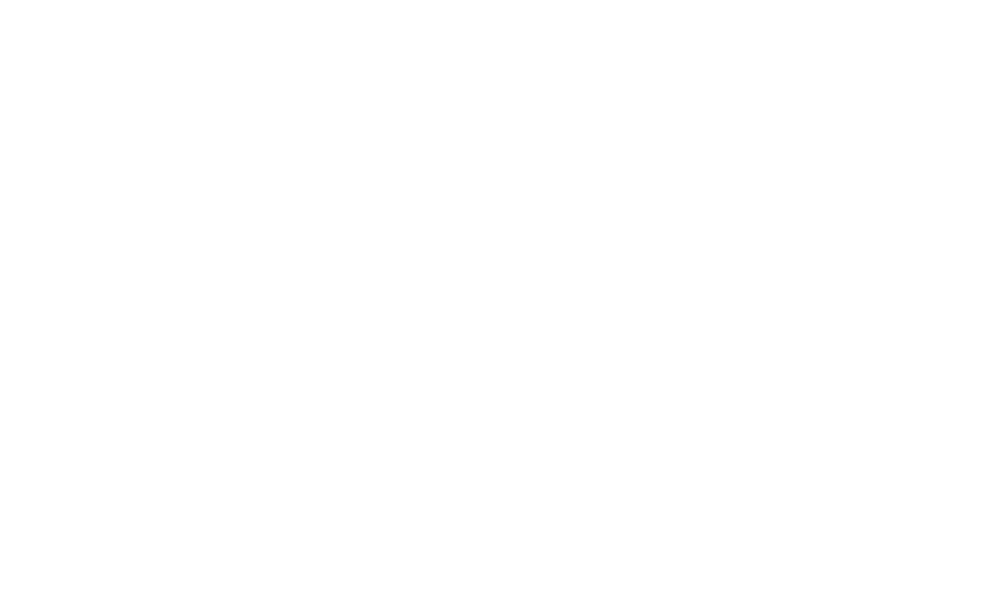

In [108]:
result = np.abs(beg-sp)
fig = plt.figure(figsize=(10,6))
plt.imshow(result, interpolation="bicubic", cmap=plt.cm.RdBu)
plt.title('abs difference $\rho_0 - \rho(T )$', size=14,)
plt.colorbar()
plt.ion()   # set interective mode
plt.show()

In [109]:
np.sum(result)

0.6724877756071499

In [110]:
#result

<IPython.core.display.Javascript object>


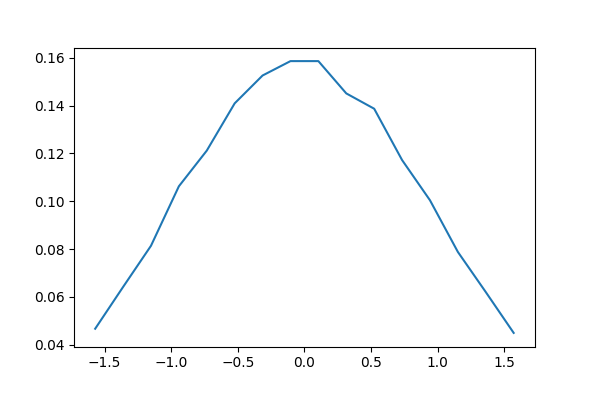

In [111]:
# конечный результат в разрезе
plt.plot(f,sp[:,int(nx/2)])
plt.show()
# нууу, кривовато, зато держит форму купола